# Data Preprocessing Pipeline for Derivative Hedging RL

This notebook processes raw market data into clean, feature-engineered datasets ready for RL model training.

## Contents
1. **Setup & Imports** - Load libraries and configure paths
2. **Load Raw Data** - Read all raw CSV files
3. **Data Exploration** - Understand data structure and quality
4. **Data Cleaning** - Handle missing values, outliers, and inconsistencies
5. **Feature Engineering** - Create returns, volatility, technical indicators
6. **Data Merging** - Combine datasets and align dates
7. **Option Features** - Calculate Greeks and option-specific features
8. **Save Processed Data** - Export to `data/processed/`
9. **Validation** - Verify processed data quality

---

## 1. Setup & Imports

In [274]:
# Standard libraries
import os
import sys
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
sys.path.append(str(Path.cwd().parent))
from src.data.preprocessing import DataPreprocessor, FeatureEngineer
from src.pricing.black_scholes import BlackScholesModel

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Paths
RAW_DATA_DIR = Path('../data/raw')
PROCESSED_DATA_DIR = Path('../data/processed')
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Imports successful")
print(f"✓ Raw data directory: {RAW_DATA_DIR.absolute()}")
print(f"✓ Processed data directory: {PROCESSED_DATA_DIR.absolute()}")

✓ Imports successful
✓ Raw data directory: e:\Derivative_Hedging_RL\notebooks\..\data\raw
✓ Processed data directory: e:\Derivative_Hedging_RL\notebooks\..\data\processed


## 2. Load Raw Data

Load all raw data files from the `data/raw/` directory.

In [275]:
# List all raw data files
raw_files = list(RAW_DATA_DIR.glob('*.csv')) + list(RAW_DATA_DIR.glob('*.npy'))
print(f"Found {len(raw_files)} raw data files:\n")
for file in sorted(raw_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  • {file.name:30s} ({size_mb:.2f} MB)")

Found 10 raw data files:

  • AAPL_daily.csv                 (0.25 MB)
  • GLD_daily.csv                  (0.25 MB)
  • IWM_daily.csv                  (0.25 MB)
  • QQQ_daily.csv                  (0.25 MB)
  • SPY_calls_chain.csv            (0.06 MB)
  • SPY_daily.csv                  (0.25 MB)
  • SPY_puts_chain.csv             (0.07 MB)
  • US_Treasury_10Y.csv            (0.27 MB)
  • VIX_daily.csv                  (0.23 MB)
  • VIX_History.csv                (0.44 MB)


### 2.1 Load Stock/ETF Daily Data

In [276]:
# Load daily stock data
tickers = ['SPY', 'AAPL', 'QQQ', 'IWM', 'GLD', 'VIX']
stock_data = {}

for ticker in tickers:
    file_path = RAW_DATA_DIR / f"{ticker}_daily.csv"
    if file_path.exists():
        # Read CSV, skip the ticker row (row 1) and date label row (row 2)
        # index_col=0 tells pandas the first column ('Price' column) contains the dates
        df = pd.read_csv(file_path, skiprows=[1, 2], index_col=0)
        
        # Rename index to 'Date' and parse as datetime
        df.index.name = 'Date'
        df.index = pd.to_datetime(df.index)
        
        # Drop 'Price' column if it exists (it's the date column, now the index)
        if 'Price' in df.columns:
            df = df.drop(columns=['Price'])
        
        # Convert to float
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        stock_data[ticker] = df
        print(f"✓ Loaded {ticker}: {len(df)} rows, {df.index.min()} to {df.index.max()}")
    else:
        print(f"✗ File not found: {file_path.name}")

print(f"\nLoaded {len(stock_data)} stock/ETF datasets")

✓ Loaded SPY: 2765 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
✓ Loaded AAPL: 2765 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
✓ Loaded QQQ: 2765 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
✓ Loaded IWM: 2765 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
✓ Loaded GLD: 2765 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
✓ Loaded VIX: 2765 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00

Loaded 6 stock/ETF datasets


### 2.2 Load Options Chain Data

In [277]:
# Load SPY options chain
calls_path = RAW_DATA_DIR / 'SPY_calls_chain.csv'
puts_path = RAW_DATA_DIR / 'SPY_puts_chain.csv'

if calls_path.exists():
    spy_calls = pd.read_csv(calls_path)
    spy_calls['lastTradeDate'] = pd.to_datetime(spy_calls['lastTradeDate'])
    
    # Handle expiry column - check if it exists
    if 'expiry' in spy_calls.columns:
        spy_calls['expiry'] = pd.to_datetime(spy_calls['expiry'])
    elif 'expirationDate' in spy_calls.columns:
        spy_calls['expiry'] = pd.to_datetime(spy_calls['expirationDate'])
    
    # Add option type
    spy_calls['option_type'] = 'call'
    
    print(f"✓ Loaded SPY calls: {len(spy_calls)} contracts")
    print(f"  Strike range: ${spy_calls['strike'].min():.0f} - ${spy_calls['strike'].max():.0f}")
else:
    spy_calls = pd.DataFrame()
    print("✗ SPY calls data not found")

if puts_path.exists():
    spy_puts = pd.read_csv(puts_path)
    spy_puts['lastTradeDate'] = pd.to_datetime(spy_puts['lastTradeDate'])
    
    # Handle expiry column - check if it exists
    if 'expiry' in spy_puts.columns:
        spy_puts['expiry'] = pd.to_datetime(spy_puts['expiry'])
    elif 'expirationDate' in spy_puts.columns:
        spy_puts['expiry'] = pd.to_datetime(spy_puts['expirationDate'])
    
    # Add option type
    spy_puts['option_type'] = 'put'
    
    print(f"✓ Loaded SPY puts: {len(spy_puts)} contracts")
    print(f"  Strike range: ${spy_puts['strike'].min():.0f} - ${spy_puts['strike'].max():.0f}")
else:
    spy_puts = pd.DataFrame()
    print("✗ SPY puts data not found")

# Combine calls and puts
spy_options = pd.concat([spy_calls, spy_puts], ignore_index=True)
print(f"\n✓ Total SPY options: {len(spy_options)} contracts")

✓ Loaded SPY calls: 479 contracts
  Strike range: $335 - $950
✓ Loaded SPY puts: 490 contracts
  Strike range: $335 - $805

✓ Total SPY options: 969 contracts


### 2.3 Load VIX Historical Data

In [278]:
# Load VIX historical data from CBOE
vix_history_path = RAW_DATA_DIR / 'VIX_History.csv'

if vix_history_path.exists():
    # Read first to inspect structure
    vix_history = pd.read_csv(vix_history_path, skiprows=1)
    
    # Print columns for debugging
    print(f"VIX History columns: {vix_history.columns.tolist()}")
    
    # Standardize column names to uppercase
    vix_history.columns = vix_history.columns.str.strip().str.upper()
    
    # Find the date column (handle different possible names)
    date_col = None
    for col in vix_history.columns:
        if 'DATE' in col.upper():
            date_col = col
            break
    
    if date_col is None:
        # If no DATE column, assume first column is date
        date_col = vix_history.columns[0]
        print(f"  Using first column as date: {date_col}")
    
    # Set date as index
    vix_history[date_col] = pd.to_datetime(vix_history[date_col])
    vix_history = vix_history.set_index(date_col)
    vix_history.index.name = 'Date'
    
    print(f"✓ Loaded VIX history: {len(vix_history)} rows")
    print(f"  Date range: {vix_history.index.min()} to {vix_history.index.max()}")
    
    # Check for CLOSE column
    if 'CLOSE' in vix_history.columns:
        print(f"  VIX range: {vix_history['CLOSE'].min():.2f} - {vix_history['CLOSE'].max():.2f}")
    else:
        print(f"  Available columns: {vix_history.columns.tolist()}")
else:
    print("✗ VIX history not found, using VIX from stock data instead")
    vix_history = stock_data.get('VIX', pd.DataFrame())

VIX History columns: ['01/02/1990', '17.240000', '17.240000.1', '17.240000.2', '17.240000.3']
  Using first column as date: 01/02/1990
✓ Loaded VIX history: 9125 rows
  Date range: 1990-01-03 00:00:00 to 2026-02-19 00:00:00
  Available columns: ['17.240000', '17.240000.1', '17.240000.2', '17.240000.3']


### 2.4 Load US Treasury Yields (Risk-Free Rate)

In [279]:
# Load 10-Year Treasury yields
treasury_path = RAW_DATA_DIR / 'US_Treasury_10Y.csv'

if treasury_path.exists():
    treasury = pd.read_csv(treasury_path)
    treasury['observation_date'] = pd.to_datetime(treasury['observation_date'])
    treasury = treasury.set_index('observation_date')
    treasury.columns = ['risk_free_rate']
    
    # Convert percentage to decimal and handle missing values
    treasury['risk_free_rate'] = pd.to_numeric(treasury['risk_free_rate'], errors='coerce') / 100
    treasury = treasury.dropna()
    
    print(f"✓ Loaded Treasury yields: {len(treasury)} rows")
    print(f"  Date range: {treasury.index.min()} to {treasury.index.max()}")
    print(f"  Rate range: {treasury['risk_free_rate'].min():.4f} - {treasury['risk_free_rate'].max():.4f}")
else:
    print("✗ Treasury data not found, will use constant rate r=0.05")
    treasury = pd.DataFrame()

✓ Loaded Treasury yields: 16016 rows
  Date range: 1962-01-02 00:00:00 to 2026-02-18 00:00:00
  Rate range: 0.0052 - 0.1584


### 2.5 Load Synthetic Data

In [280]:
# Load synthetic GBM paths
gbm_path = RAW_DATA_DIR.parent / 'synthetic' / 'gbm_paths_10k.npy'

if gbm_path.exists():
    gbm_paths = np.load(gbm_path)
    print(f"✓ Loaded synthetic GBM paths: {gbm_paths.shape}")
    print(f"  {gbm_paths.shape[0]} paths, {gbm_paths.shape[1]} time steps")
else:
    print("✗ Synthetic GBM paths not found")
    gbm_paths = None

✓ Loaded synthetic GBM paths: (10000, 61)
  10000 paths, 61 time steps


## 3. Data Exploration

Visualize and understand the loaded data.

In [281]:
# Display summary statistics for SPY
if 'SPY' in stock_data:
    print("=" * 70)
    print("SPY Data Summary")
    print("=" * 70)
    print(stock_data['SPY'].describe())
    print("\nMissing values:")
    print(stock_data['SPY'].isnull().sum())

SPY Data Summary
             Close         High          Low         Open        Volume
count  2765.000000  2765.000000  2765.000000  2765.000000  2.765000e+03
mean    337.806615   339.575961   335.750063   337.747894  8.608538e+07
std     140.603410   141.251149   139.813064   140.583032  4.393255e+07
min     154.980820   156.031772   152.881607   154.540096  2.027000e+07
25%     219.493988   219.906630   218.078035   219.177886  5.874230e+07
50%     300.697815   302.409131   298.968892   300.081458  7.570810e+07
75%     423.071869   425.233625   420.933118   423.413646  9.945080e+07
max     690.380005   691.659973   689.270020   690.640015  5.072443e+08

Missing values:
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


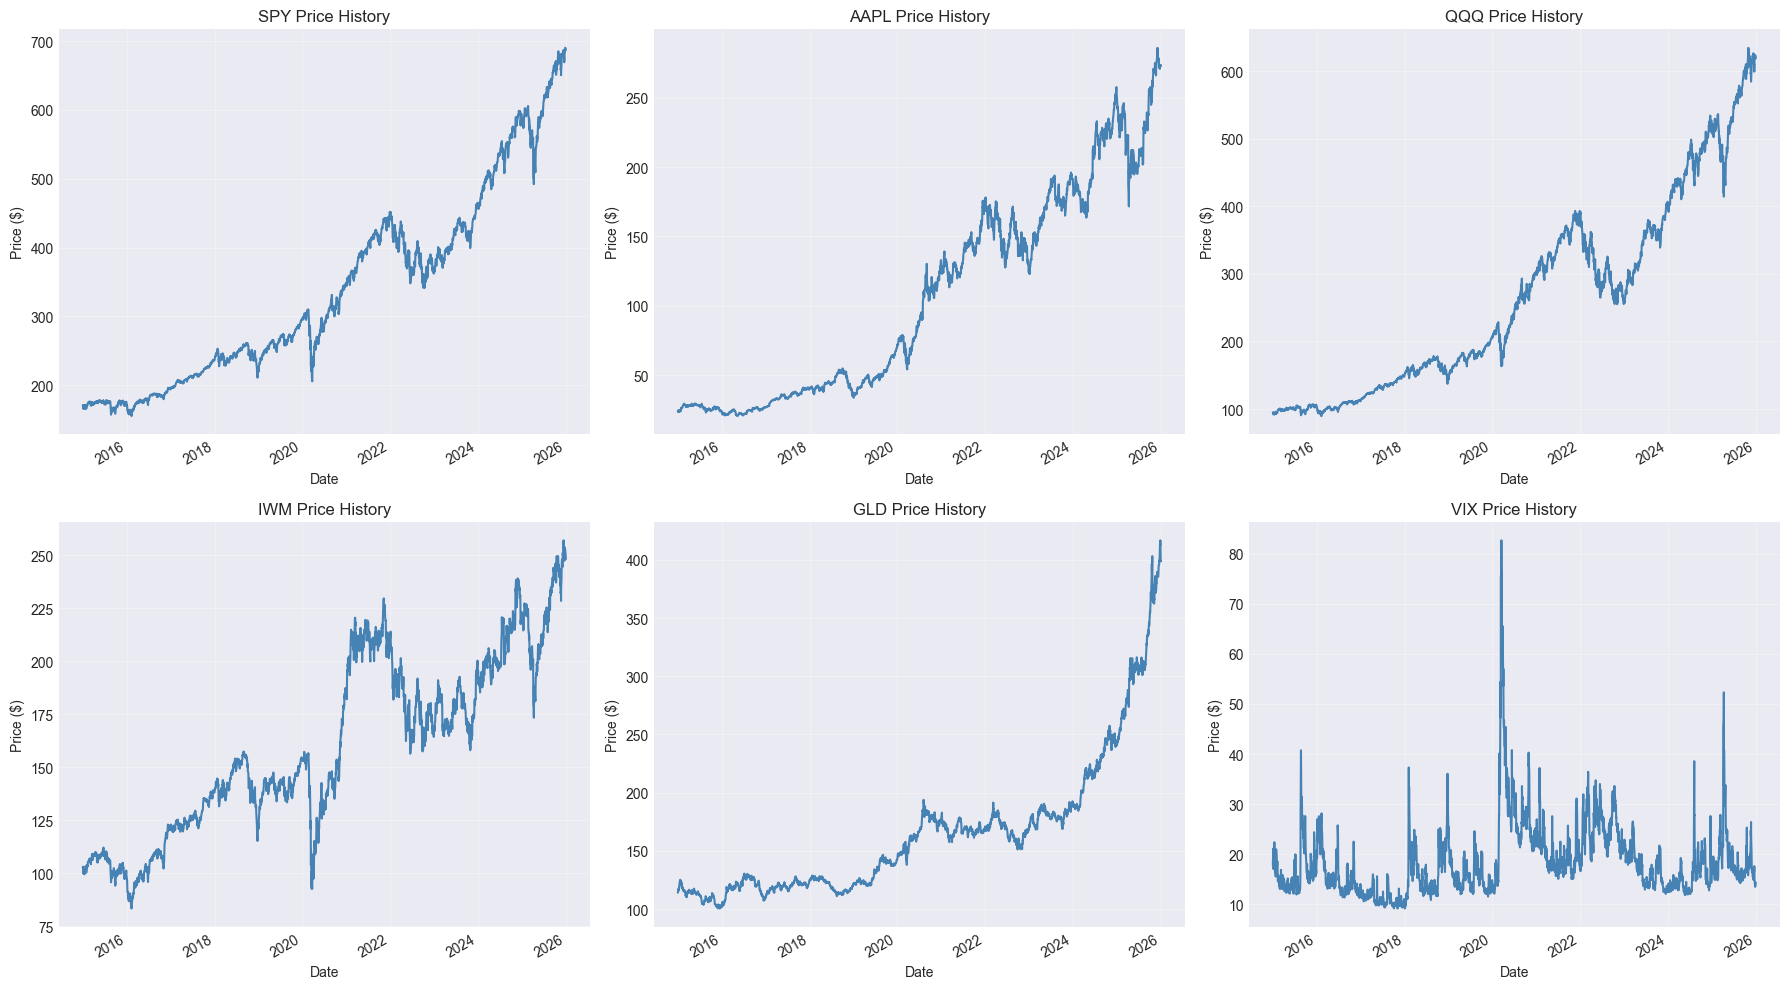

In [282]:
# Plot price history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    if ticker in stock_data:
        ax = axes[idx]
        stock_data[ticker]['Close'].plot(ax=ax, title=f'{ticker} Price History', color='steelblue', linewidth=1.5)
        ax.set_ylabel('Price ($)')
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

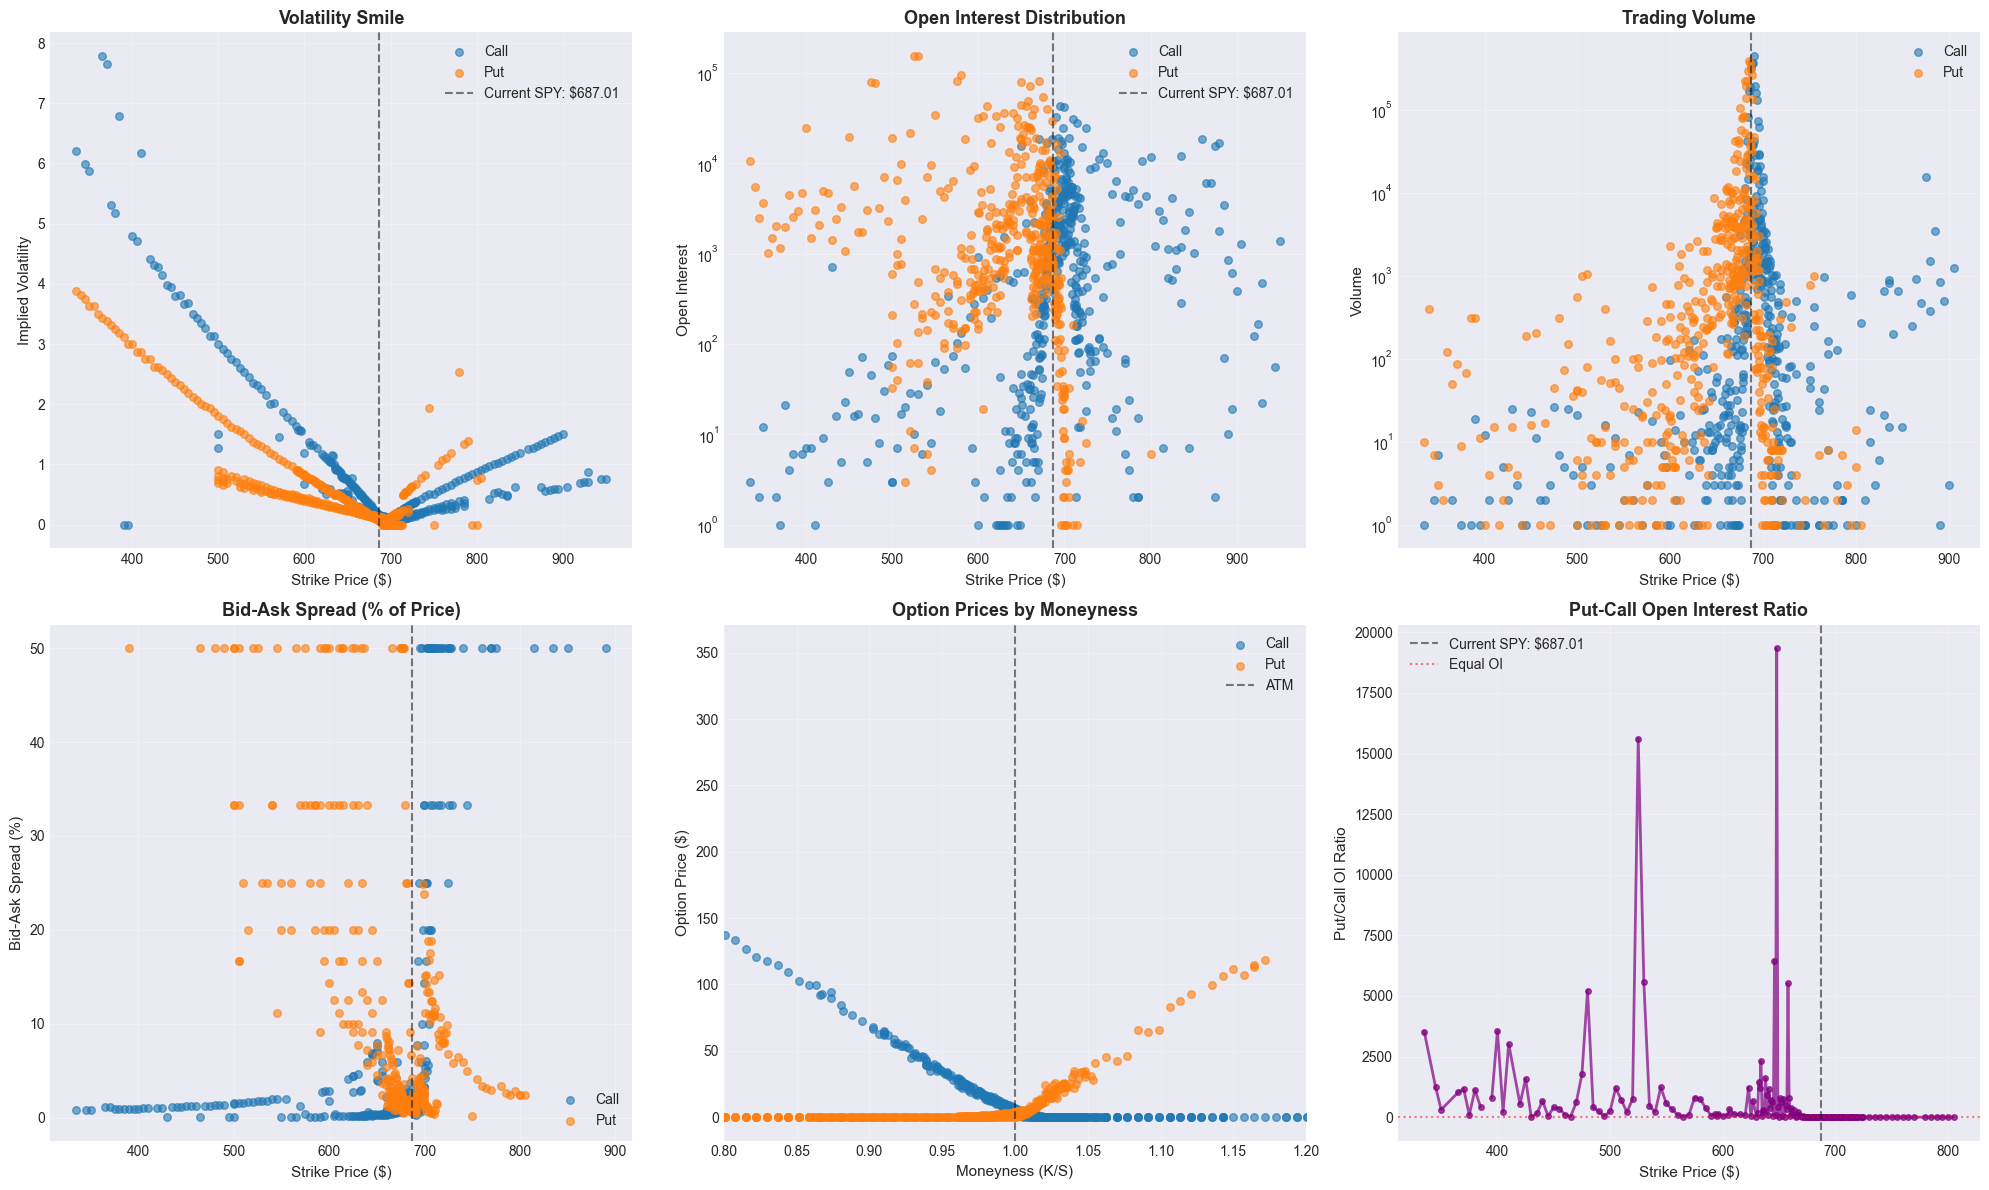


OPTIONS MARKET SUMMARY
Current SPY Price: $687.01
Total Contracts: 969
  Calls: 479
  Puts: 490

Strike Range: $335 - $950
Implied Vol Range: 0.00% - 778.81%
Total Open Interest: 3,939,891
Put/Call OI Ratio: 2.26


In [283]:
# Visualize options data
if not spy_options.empty:
    # Get current SPY price for reference
    current_spy = stock_data['SPY']['Close'].iloc[-1] if 'SPY' in stock_data else spy_options['strike'].median()
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Implied Volatility Smile
    for option_type in ['call', 'put']:
        data = spy_options[spy_options['option_type'] == option_type]
        axes[0, 0].scatter(data['strike'], data['impliedVolatility'], 
                          alpha=0.6, label=option_type.capitalize(), s=30)
    axes[0, 0].axvline(current_spy, color='black', linestyle='--', alpha=0.5, label=f'Current SPY: ${current_spy:.2f}')
    axes[0, 0].set_xlabel('Strike Price ($)', fontsize=11)
    axes[0, 0].set_ylabel('Implied Volatility', fontsize=11)
    axes[0, 0].set_title('Volatility Smile', fontsize=13, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Open Interest Distribution
    for option_type in ['call', 'put']:
        data = spy_options[spy_options['option_type'] == option_type]
        axes[0, 1].scatter(data['strike'], data['openInterest'], 
                          alpha=0.6, label=option_type.capitalize(), s=30)
    axes[0, 1].axvline(current_spy, color='black', linestyle='--', alpha=0.5, label=f'Current SPY: ${current_spy:.2f}')
    axes[0, 1].set_xlabel('Strike Price ($)', fontsize=11)
    axes[0, 1].set_ylabel('Open Interest', fontsize=11)
    axes[0, 1].set_title('Open Interest Distribution', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')  # Log scale for better visualization
    
    # 3. Volume Analysis
    if 'volume' in spy_options.columns:
        for option_type in ['call', 'put']:
            data = spy_options[spy_options['option_type'] == option_type]
            data_clean = data[data['volume'].notna() & (data['volume'] > 0)]
            axes[0, 2].scatter(data_clean['strike'], data_clean['volume'], 
                              alpha=0.6, label=option_type.capitalize(), s=30)
        axes[0, 2].axvline(current_spy, color='black', linestyle='--', alpha=0.5)
        axes[0, 2].set_xlabel('Strike Price ($)', fontsize=11)
        axes[0, 2].set_ylabel('Volume', fontsize=11)
        axes[0, 2].set_title('Trading Volume', fontsize=13, fontweight='bold')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        axes[0, 2].set_yscale('log')
    
    # 4. Bid-Ask Spread Analysis
    if 'bid' in spy_options.columns and 'ask' in spy_options.columns:
        spy_options['spread'] = spy_options['ask'] - spy_options['bid']
        spy_options['spread_pct'] = (spy_options['spread'] / spy_options['lastPrice']) * 100
        
        for option_type in ['call', 'put']:
            data = spy_options[spy_options['option_type'] == option_type]
            data_clean = data[data['spread_pct'].notna() & (data['spread_pct'] < 100)]
            axes[1, 0].scatter(data_clean['strike'], data_clean['spread_pct'], 
                              alpha=0.6, label=option_type.capitalize(), s=30)
        axes[1, 0].axvline(current_spy, color='black', linestyle='--', alpha=0.5)
        axes[1, 0].set_xlabel('Strike Price ($)', fontsize=11)
        axes[1, 0].set_ylabel('Bid-Ask Spread (%)', fontsize=11)
        axes[1, 0].set_title('Bid-Ask Spread (% of Price)', fontsize=13, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Option Prices by Moneyness
    spy_options['moneyness_simple'] = spy_options['strike'] / current_spy
    
    for option_type in ['call', 'put']:
        data = spy_options[spy_options['option_type'] == option_type]
        axes[1, 1].scatter(data['moneyness_simple'], data['lastPrice'], 
                          alpha=0.6, label=option_type.capitalize(), s=30)
    axes[1, 1].axvline(1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
    axes[1, 1].set_xlabel('Moneyness (K/S)', fontsize=11)
    axes[1, 1].set_ylabel('Option Price ($)', fontsize=11)
    axes[1, 1].set_title('Option Prices by Moneyness', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0.8, 1.2)  # Focus on ±20% around ATM
    
    # 6. Put-Call Volume Ratio
    call_oi = spy_options[spy_options['option_type'] == 'call'].groupby('strike')['openInterest'].sum()
    put_oi = spy_options[spy_options['option_type'] == 'put'].groupby('strike')['openInterest'].sum()
    
    common_strikes = call_oi.index.intersection(put_oi.index)
    pc_ratio = put_oi[common_strikes] / call_oi[common_strikes]
    
    axes[1, 2].plot(common_strikes, pc_ratio, marker='o', linestyle='-', 
                    color='purple', linewidth=2, markersize=4, alpha=0.7)
    axes[1, 2].axvline(current_spy, color='black', linestyle='--', alpha=0.5, label=f'Current SPY: ${current_spy:.2f}')
    axes[1, 2].axhline(1.0, color='red', linestyle=':', alpha=0.5, label='Equal OI')
    axes[1, 2].set_xlabel('Strike Price ($)', fontsize=11)
    axes[1, 2].set_ylabel('Put/Call OI Ratio', fontsize=11)
    axes[1, 2].set_title('Put-Call Open Interest Ratio', fontsize=13, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("OPTIONS MARKET SUMMARY")
    print("="*70)
    print(f"Current SPY Price: ${current_spy:.2f}")
    print(f"Total Contracts: {len(spy_options)}")
    print(f"  Calls: {len(spy_options[spy_options['option_type'] == 'call'])}")
    print(f"  Puts: {len(spy_options[spy_options['option_type'] == 'put'])}")
    print(f"\nStrike Range: ${spy_options['strike'].min():.0f} - ${spy_options['strike'].max():.0f}")
    print(f"Implied Vol Range: {spy_options['impliedVolatility'].min():.2%} - {spy_options['impliedVolatility'].max():.2%}")
    print(f"Total Open Interest: {spy_options['openInterest'].sum():,.0f}")
    print(f"Put/Call OI Ratio: {spy_options[spy_options['option_type']=='put']['openInterest'].sum() / spy_options[spy_options['option_type']=='call']['openInterest'].sum():.2f}")
else:
    print("⚠ No options data to visualize")

## 4. Data Cleaning

Handle missing values, outliers, and ensure data quality.

In [284]:
# Initialize preprocessor
preprocessor = DataPreprocessor()

# Clean stock data
cleaned_stock_data = {}

for ticker, df in stock_data.items():
    print(f"\nCleaning {ticker}...")

    # Forward fill missing values using modern pandas method
    df_clean = df.copy()
    df_clean = df_clean.ffill()  # Modern replacement for fillna(method='ffill')

    # Drop remaining NaN values if any
    if df_clean.isnull().sum().sum() > 0:
        remaining_nans = df_clean.isnull().sum().sum()
        print(f"  Remaining NaN values: {remaining_nans}")
        df_clean = df_clean.dropna()

    # Remove extreme outliers (conservative 5 std)
    price_cols = [col for col in ['Close', 'High', 'Low', 'Open'] if col in df_clean.columns]

    if price_cols:
        before_rows = len(df_clean)
        # Remove outliers using manual calculation since preprocessor may have deprecated methods
        for col in price_cols:
            mean = df_clean[col].mean()
            std = df_clean[col].std()
            lower = mean - 5.0 * std
            upper = mean + 5.0 * std
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        
        after_rows = len(df_clean)
        if before_rows != after_rows:
            print(f"  Removed {before_rows - after_rows} outlier rows")

    cleaned_stock_data[ticker] = df_clean
    print(f"  ✓ Clean data: {len(df_clean)} rows")

print("\n✓ Data cleaning complete")


Cleaning SPY...
  ✓ Clean data: 2765 rows

Cleaning AAPL...
  ✓ Clean data: 2765 rows

Cleaning QQQ...
  ✓ Clean data: 2765 rows

Cleaning IWM...
  ✓ Clean data: 2765 rows

Cleaning GLD...
  ✓ Clean data: 2765 rows

Cleaning VIX...
  Removed 26 outlier rows
  ✓ Clean data: 2739 rows

✓ Data cleaning complete


## 5. Feature Engineering

Create returns, volatility, and technical indicators.

In [285]:
# Add features to each ticker
featured_stock_data = {}

for ticker, df in cleaned_stock_data.items():
    print(f"\nEngineering features for {ticker}...")
    df_feat = df.copy()
    
    # Add returns manually (avoid preprocessor issues)
    df_feat['returns'] = df_feat['Close'].pct_change()
    df_feat['log_returns'] = np.log(df_feat['Close'] / df_feat['Close'].shift(1))
    print(f"  ✓ Added returns")
    
    # Add technical indicators manually
    df_feat['sma_20'] = df_feat['Close'].rolling(window=20).mean()
    df_feat['sma_50'] = df_feat['Close'].rolling(window=50).mean()
    df_feat['ema_20'] = df_feat['Close'].ewm(span=20, adjust=False).mean()
    
    # Volatility (rolling std of returns)
    df_feat['volatility_20'] = df_feat['returns'].rolling(window=20).std()
    
    # Volume moving average (if volume exists)
    if 'Volume' in df_feat.columns:
        df_feat['volume_sma_20'] = df_feat['Volume'].rolling(window=20).mean()
    
    print(f"  ✓ Added technical indicators")
    
    # Add rolling statistics
    df_feat['returns_std_20'] = df_feat['returns'].rolling(window=20).std()
    df_feat['returns_mean_20'] = df_feat['returns'].rolling(window=20).mean()
    print(f"  ✓ Added rolling statistics")
    
    # Add price momentum
    df_feat['momentum_5'] = df_feat['Close'].pct_change(periods=5)
    df_feat['momentum_10'] = df_feat['Close'].pct_change(periods=10)
    df_feat['momentum_20'] = df_feat['Close'].pct_change(periods=20)
    print(f"  ✓ Added momentum features")
    
    # Add high-low range
    if 'High' in df_feat.columns and 'Low' in df_feat.columns:
        df_feat['hl_range'] = (df_feat['High'] - df_feat['Low']) / df_feat['Close']
        print(f"  ✓ Added high-low range")
    
    # Drop rows with NaN from feature calculation
    df_feat = df_feat.dropna()
    
    featured_stock_data[ticker] = df_feat
    print(f"  ✓ Final shape: {df_feat.shape}")

print("\n✓ Feature engineering complete")


Engineering features for SPY...
  ✓ Added returns
  ✓ Added technical indicators
  ✓ Added rolling statistics
  ✓ Added momentum features
  ✓ Added high-low range
  ✓ Final shape: (2716, 18)

Engineering features for AAPL...
  ✓ Added returns
  ✓ Added technical indicators
  ✓ Added rolling statistics
  ✓ Added momentum features
  ✓ Added high-low range
  ✓ Final shape: (2716, 18)

Engineering features for QQQ...
  ✓ Added returns
  ✓ Added technical indicators
  ✓ Added rolling statistics
  ✓ Added momentum features
  ✓ Added high-low range
  ✓ Final shape: (2716, 18)

Engineering features for IWM...
  ✓ Added returns
  ✓ Added technical indicators
  ✓ Added rolling statistics
  ✓ Added momentum features
  ✓ Added high-low range
  ✓ Final shape: (2716, 18)

Engineering features for GLD...
  ✓ Added returns
  ✓ Added technical indicators
  ✓ Added rolling statistics
  ✓ Added momentum features
  ✓ Added high-low range
  ✓ Final shape: (2716, 18)

Engineering features for VIX...
  ✓ Ad

In [286]:
# Display SPY with new features
if 'SPY' in featured_stock_data:
    print("SPY with engineered features:")
    print(f"Shape: {featured_stock_data['SPY'].shape}")
    print(f"\nColumns: {featured_stock_data['SPY'].columns.tolist()}")
    print("\nFirst few rows:")
    display(featured_stock_data['SPY'].head())

SPY with engineered features:
Shape: (2716, 18)

Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'returns', 'log_returns', 'sma_20', 'sma_50', 'ema_20', 'volatility_20', 'volume_sma_20', 'returns_std_20', 'returns_mean_20', 'momentum_5', 'momentum_10', 'momentum_20', 'hl_range']

First few rows:


,Close,High,Low,Open,Volume,returns,log_returns,sma_20,sma_50,ema_20,volatility_20,volume_sma_20,returns_std_20,returns_mean_20,momentum_5,momentum_10,momentum_20,hl_range
Date,,,,,,,,,,,,,,,,,,
2015-03-16,173.205383,173.296728,170.946687,171.652534,136099200,0.013361,0.013272,173.919544,171.063120,172.752049,0.007242,105880195.0,0.007242,-0.000262,0.001056,-0.016086,-0.005720,0.013568
2015-03-17,172.690552,173.072530,171.876748,172.466339,94510400,-0.002972,-0.002977,173.830273,171.105139,172.746192,0.007253,106757305.0,0.007253,-0.000489,0.014538,-0.014968,-0.010233,0.006924
2015-03-18,174.766586,175.439211,171.577830,172.217244,228808500,0.012022,0.011950,173.843975,171.250295,172.938611,0.007775,114165085.0,0.007775,0.000107,0.029145,0.001094,0.001571,0.022095
2015-03-19,173.969360,174.774852,173.579070,174.351351,117917300,-0.004562,-0.004572,173.824046,171.411061,173.036777,0.007844,115487825.0,0.007844,-0.000085,0.011589,-0.004562,-0.002286,0.006874
2015-03-20,175.504959,176.013766,174.737580,174.921085,177715100,0.008827,0.008788,173.828582,171.561185,173.271842,0.007983,117328760.0,0.007983,0.000056,0.026815,0.018551,0.000517,0.007272


## 6. Data Merging

Merge stock data with VIX and risk-free rate data.

In [305]:
# Create main dataset starting with SPY
if 'SPY' in featured_stock_data:
    main_df = featured_stock_data['SPY'].copy()
    main_df.columns = [f'SPY_{col}' if col not in ['Date'] else col for col in main_df.columns]
    
    print(f"Starting with SPY: {main_df.shape}")
    print(f"Date range: {main_df.index.min()} to {main_df.index.max()}")
else:
    raise ValueError("SPY data not available!")

Starting with SPY: (2716, 18)
Date range: 2015-03-16 00:00:00 to 2025-12-30 00:00:00


In [306]:
# Add VIX data
if not vix_history.empty:
    # Debug: print available columns
    print(f"Available VIX columns: {vix_history.columns.tolist()}")
    
    # Find the VIX value column (try different possible names)
    possible_vix_cols = ['CLOSE', 'VIX', 'PRICE', 'VALUE', 'VIXCLOSE']
    vix_col = None
    for col in possible_vix_cols:
        if col in vix_history.columns:
            vix_col = col
            break
    
    if vix_col is None:
        # If no standard column found, use the first non-date numeric column
        numeric_cols = vix_history.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            vix_col = numeric_cols[0]
            print(f"Using first numeric column: {vix_col}")
        else:
            raise ValueError(f"Cannot find VIX value column. Available columns: {vix_history.columns.tolist()}")
    
    vix_df = vix_history[[vix_col]].copy()
    vix_df.columns = ['VIX']
    
    # Merge with main dataframe
    main_df = main_df.join(vix_df, how='left')
    
    # Forward fill VIX for missing dates
    main_df['VIX'] = main_df['VIX'].ffill()
    
    print(f"✓ Added VIX data from '{vix_col}' column: {main_df['VIX'].notna().sum()} non-null values")
elif 'VIX' in featured_stock_data:
    vix_df = featured_stock_data['VIX'][['Close']].copy()
    vix_df.columns = ['VIX']
    main_df = main_df.join(vix_df, how='left')
    main_df['VIX'] = main_df['VIX'].ffill()
    print(f"✓ Added VIX from stock data: {main_df['VIX'].notna().sum()} non-null values")
else:
    print("⚠ VIX data not available, using default volatility")
    main_df['VIX'] = 20.0  # Default VIX value

Available VIX columns: ['17.240000', '17.240000.1', '17.240000.2', '17.240000.3']
Using first numeric column: 17.240000
✓ Added VIX data from '17.240000' column: 2716 non-null values


In [307]:
# Add risk-free rate
if not treasury.empty:
    # Merge treasury data
    main_df = main_df.join(treasury, how='left')
    
    # Forward fill for missing dates (weekends/holidays)
    main_df['risk_free_rate'] = main_df['risk_free_rate'].ffill()
    
    # Backward fill any remaining NaN at the beginning
    main_df['risk_free_rate'] = main_df['risk_free_rate'].bfill()
    
    print(f"✓ Added risk-free rate: {main_df['risk_free_rate'].notna().sum()} non-null values")
    print(f"  Average rate: {main_df['risk_free_rate'].mean():.4f}")
else:
    print("⚠ Treasury data not available, using constant rate r=0.05")
    main_df['risk_free_rate'] = 0.05

✓ Added risk-free rate: 2716 non-null values
  Average rate: 0.0266


In [308]:
# Add other tickers as additional features (optional)
other_tickers = ['AAPL', 'QQQ', 'IWM', 'GLD']

for ticker in other_tickers:
    if ticker in featured_stock_data:
        ticker_df = featured_stock_data[ticker][['Close', 'returns', 'volatility_20']].copy()
        ticker_df.columns = [f'{ticker}_{col}' for col in ticker_df.columns]
        
        main_df = main_df.join(ticker_df, how='left')
        main_df = main_df.ffill()
        
        print(f"✓ Added {ticker} features")

✓ Added AAPL features
✓ Added QQQ features
✓ Added IWM features
✓ Added GLD features


In [309]:
# Final cleanup - remove any remaining NaN
print(f"\nBefore final cleanup: {main_df.shape}")
print(f"NaN values per column:\n{main_df.isnull().sum()[main_df.isnull().sum() > 0]}")

main_df = main_df.dropna()

print(f"\n✓ After cleanup: {main_df.shape}")
print(f"Date range: {main_df.index.min()} to {main_df.index.max()}")


Before final cleanup: (2716, 32)
NaN values per column:
Series([], dtype: int64)

✓ After cleanup: (2716, 32)
Date range: 2015-03-16 00:00:00 to 2025-12-30 00:00:00


In [310]:
# Diagnostic: Check current state of main_df
print("="*70)
print("DATA DIAGNOSTIC")
print("="*70)

if 'main_df' in locals():
    print(f"\n✓ main_df exists")
    print(f"  Shape: {main_df.shape}")
    print(f"  Rows: {len(main_df)}")
    
    if len(main_df) == 0:
        print("\n⚠️ WARNING: main_df is EMPTY!")
        print("\nLet's check the source data:")
        
        # Check featured_stock_data
        if 'featured_stock_data' in locals() and 'SPY' in featured_stock_data:
            spy_df = featured_stock_data['SPY']
            print(f"\n  SPY in featured_stock_data: {spy_df.shape}")
            print(f"  Date range: {spy_df.index.min()} to {spy_df.index.max()}")
            print(f"  First few dates: {spy_df.index[:5].tolist()}")
        
        # Check VIX history
        if 'vix_history' in locals() and not vix_history.empty:
            print(f"\n  VIX history: {vix_history.shape}")
            print(f"  Date range: {vix_history.index.min()} to {vix_history.index.max()}")
            print(f"  First few dates: {vix_history.index[:5].tolist()}")
        
        # Check treasury
        if 'treasury' in locals() and not treasury.empty:
            print(f"\n  Treasury: {treasury.shape}")
            print(f"  Date range: {treasury.index.min()} to {treasury.index.max()}")
            
        print("\n💡 SOLUTION: Re-run cells 24-28 to rebuild main_df")
    else:
        print(f"\n✓ main_df has data!")
        print(f"  Date range: {main_df.index.min()} to {main_df.index.max()}")
        print(f"  Columns: {len(main_df.columns)}")
        print(f"\nFirst 3 rows:")
        display(main_df.head(3))
else:
    print("\n✗ main_df does NOT exist yet!")
    print("   You need to run cells 24-28 first")

print("\n" + "="*70)

DATA DIAGNOSTIC

✓ main_df exists
  Shape: (2716, 32)
  Rows: 2716

✓ main_df has data!
  Date range: 2015-03-16 00:00:00 to 2025-12-30 00:00:00
  Columns: 32

First 3 rows:


,SPY_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume,SPY_returns,SPY_log_returns,SPY_sma_20,SPY_sma_50,SPY_ema_20,SPY_volatility_20,SPY_volume_sma_20,SPY_returns_std_20,SPY_returns_mean_20,SPY_momentum_5,SPY_momentum_10,SPY_momentum_20,SPY_hl_range,VIX,risk_free_rate,AAPL_Close,AAPL_returns,AAPL_volatility_20,QQQ_Close,QQQ_returns,QQQ_volatility_20,IWM_Close,IWM_returns,IWM_volatility_20,GLD_Close,GLD_returns,GLD_volatility_20
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-03-16,173.205383,173.296728,170.946687,171.652534,136099200,0.013361,0.013272,173.919544,171.063120,172.752049,0.007242,105880195.0,0.007242,-0.000262,0.001056,-0.016086,-0.005720,0.013568,15.78,0.0210,27.783697,0.011004,0.013712,98.246544,0.012911,0.007217,106.779350,0.005872,0.006615,110.809998,-0.000631,0.007284
2015-03-17,172.690552,173.072530,171.876748,172.466339,94510400,-0.002972,-0.002977,173.830273,171.105139,172.746192,0.007253,106757305.0,0.007253,-0.000489,0.014538,-0.014968,-0.010233,0.006924,16.31,0.0206,28.248434,0.016727,0.014193,98.403061,0.001593,0.007223,107.065071,0.002676,0.006608,110.209999,-0.005415,0.006578
2015-03-18,174.766586,175.439211,171.577830,172.217244,228808500,0.012022,0.011950,173.843975,171.250295,172.938611,0.007775,114165085.0,0.007775,0.000107,0.029145,0.001094,0.001571,0.022095,14.60,0.0193,28.566404,0.011256,0.014339,99.369865,0.009825,0.007550,107.922203,0.008006,0.006805,112.370003,0.019599,0.008173


In [311]:
# Quick Fix: Rebuild main_df from scratch if it's empty

if 'main_df' not in locals() or len(main_df) == 0:
    print("🔧 Rebuilding main_df from featured_stock_data...\n")
    
    # Step 1: Start with SPY
    if 'featured_stock_data' in locals() and 'SPY' in featured_stock_data:
        main_df = featured_stock_data['SPY'].copy()
        main_df.columns = [f'SPY_{col}' for col in main_df.columns]
        print(f"✓ Created main_df from SPY: {main_df.shape}")
        print(f"  Date range: {main_df.index.min()} to {main_df.index.max()}")
    else:
        raise ValueError("❌ Cannot find SPY in featured_stock_data!")
    
    # Step 2: Add VIX
    if 'vix_history' in locals() and not vix_history.empty:
        print(f"\n✓ Adding VIX data...")
        print(f"  VIX columns: {vix_history.columns.tolist()}")
        
        # Find VIX value column
        possible_cols = ['CLOSE', 'VIX CLOSE', 'VIXCLOSE', 'OPEN']
        vix_col = None
        for col in possible_cols:
            if col in vix_history.columns:
                vix_col = col
                break
        
        if vix_col is None:
            numeric_cols = vix_history.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                vix_col = numeric_cols[0]
        
        if vix_col:
            vix_df = vix_history[[vix_col]].copy()
            vix_df.columns = ['VIX']
            main_df = main_df.join(vix_df, how='left')
            main_df['VIX'] = main_df['VIX'].ffill().bfill()
            print(f"  ✓ Added VIX from '{vix_col}': {main_df['VIX'].notna().sum()} values")
        else:
            main_df['VIX'] = 20.0
            print(f"  ⚠ Using default VIX=20.0")
    elif 'featured_stock_data' in locals() and 'VIX' in featured_stock_data:
        vix_df = featured_stock_data['VIX'][['Close']].copy()
        vix_df.columns = ['VIX']
        main_df = main_df.join(vix_df, how='left')
        main_df['VIX'] = main_df['VIX'].ffill()
        print(f"  ✓ Added VIX from stock data")
    else:
        main_df['VIX'] = 20.0
        print(f"  ⚠ Using default VIX=20.0")
    
    # Step 3: Add treasury
    if 'treasury' in locals() and not treasury.empty:
        print(f"\n✓ Adding Treasury data...")
        main_df = main_df.join(treasury, how='left')
        main_df['risk_free_rate'] = main_df['risk_free_rate'].ffill().bfill()
        print(f"  ✓ Added risk-free rate: {main_df['risk_free_rate'].notna().sum()} values")
    else:
        main_df['risk_free_rate'] = 0.05
        print(f"  ⚠ Using default r=0.05")
    
    # Step 4: Add other tickers
    print(f"\n✓ Adding other tickers...")
    other_tickers = ['AAPL', 'QQQ', 'IWM', 'GLD']
    for ticker in other_tickers:
        if ticker in featured_stock_data:
            ticker_df = featured_stock_data[ticker][['Close', 'returns', 'volatility_20']].copy()
            ticker_df.columns = [f'{ticker}_{col}' for col in ticker_df.columns]
            main_df = main_df.join(ticker_df, how='left')
            main_df[[f'{ticker}_Close', f'{ticker}_returns', f'{ticker}_volatility_20']] = \
                main_df[[f'{ticker}_Close', f'{ticker}_returns', f'{ticker}_volatility_20']].ffill()
            print(f"  ✓ Added {ticker}")
    
    # Step 5: Final cleanup
    print(f"\n✓ Final cleanup...")
    print(f"  Before: {main_df.shape}")
    main_df = main_df.dropna()
    print(f"  After: {main_df.shape}")
    
    print(f"\n{'='*70}")
    print(f"✅ MAIN_DF REBUILT SUCCESSFULLY!")
    print(f"{'='*70}")
    print(f"  Shape: {main_df.shape}")
    print(f"  Date range: {main_df.index.min()} to {main_df.index.max()}")
    print(f"  Features: {len(main_df.columns)}")
    print(f"\nFirst 3 rows:")
    display(main_df.head(3))
else:
    print(f"✓ main_df already has data: {main_df.shape}")
    print(f"  No rebuild needed!")

✓ main_df already has data: (2716, 32)
  No rebuild needed!


### 🔧 Quick Fix: Rebuild main_df if Empty

**Run this cell to fix the empty dataset issue**

### 🔍 Data Issue Diagnostic

**Check if the dataset is empty and identify the problem**

## 7. Option Features

Process options data and calculate Greeks.

In [312]:
# Process options data
if not spy_options.empty:
    print("Processing options chain data...\n")
    
    # Ensure both datetime columns are timezone-naive for subtraction
    if spy_options['lastTradeDate'].dt.tz is not None:
        spy_options['lastTradeDate'] = spy_options['lastTradeDate'].dt.tz_localize(None)
    if spy_options['expiry'].dt.tz is not None:
        spy_options['expiry'] = spy_options['expiry'].dt.tz_localize(None)
    
    # Calculate time to maturity for each option
    spy_options['days_to_expiry'] = (spy_options['expiry'] - spy_options['lastTradeDate']).dt.days
    spy_options['time_to_maturity'] = spy_options['days_to_expiry'] / 365.0
    
    # Calculate moneyness (S/K)
    # Get most recent SPY price from available sources
    if 'main_df' in globals() and not main_df.empty and 'SPY_Close' in main_df.columns:
        current_spy_price = main_df['SPY_Close'].iloc[-1]
    elif 'featured_stock_data' in globals() and 'SPY' in featured_stock_data:
        current_spy_price = featured_stock_data['SPY']['Close'].iloc[-1]
    elif 'stock_data' in globals() and 'SPY' in stock_data:
        current_spy_price = stock_data['SPY']['Close'].iloc[-1]
    else:
        # Fallback: use median strike as proxy
        current_spy_price = spy_options['strike'].median()
        print(f"⚠ Warning: Could not find SPY price, using median strike: ${current_spy_price:.2f}")
    
    spy_options['moneyness'] = current_spy_price / spy_options['strike']
    
    # Add in-the-money indicator
    spy_options['itm'] = spy_options['inTheMoney'].astype(int)
    
    print(f"✓ Calculated time to maturity and moneyness")
    print(f"  Current SPY price: ${current_spy_price:.2f}")
    print(f"  Time to maturity range: {spy_options['time_to_maturity'].min():.3f} - {spy_options['time_to_maturity'].max():.3f} years")
    print(f"  Moneyness range: {spy_options['moneyness'].min():.3f} - {spy_options['moneyness'].max():.3f}")
    
    # Save processed options data
    options_output_path = PROCESSED_DATA_DIR / 'spy_options_processed.csv'
    spy_options.to_csv(options_output_path, index=False)
    print(f"\n✓ Saved processed options to: {options_output_path}")
else:
    print("⚠ No options data to process")

Processing options chain data...

✓ Calculated time to maturity and moneyness
  Current SPY price: $687.01
  Time to maturity range: -0.003 - 0.249 years
  Moneyness range: 0.723 - 2.051

✓ Saved processed options to: ..\data\processed\spy_options_processed.csv


In [313]:
# Calculate Greeks for sample options using Black-Scholes
if not spy_options.empty:
    print("\nCalculating Greeks for sample options...\n")
    
    bs_model = BlackScholesModel()
    
    # Sample: ATM call and put with ~30 days to expiry
    atm_strike = current_spy_price
    sample_options = spy_options[
        (spy_options['strike'] >= atm_strike - 10) & 
        (spy_options['strike'] <= atm_strike + 10) &
        (spy_options['days_to_expiry'] >= 20) &
        (spy_options['days_to_expiry'] <= 40)
    ].head(5)
    
    print(f"Sample options (near ATM, ~30 DTE):")
    
    for idx, option in sample_options.iterrows():
        S = current_spy_price
        K = option['strike']
        T = option['time_to_maturity']
        r = main_df['risk_free_rate'].iloc[-1]
        sigma = option['impliedVolatility']
        opt_type = 'call' if option['option_type'] == 'call' else 'put'
        
        # Calculate Greeks
        greeks = bs_model.greeks(S, K, T, r, sigma, opt_type)
        
        print(f"\n{opt_type.upper()} - Strike: ${K:.0f}, DTE: {option['days_to_expiry']:.0f}")
        print(f"  Delta:   {greeks['delta']:.4f}")
        print(f"  Gamma:   {greeks['gamma']:.6f}")
        print(f"  Vega:    {greeks['vega']:.4f}")
        print(f"  Theta:   {greeks['theta']:.4f}")
        print(f"  Rho:     {greeks['rho']:.4f}")


Calculating Greeks for sample options...

Sample options (near ATM, ~30 DTE):


## 8. Save Processed Data

Export cleaned and feature-engineered datasets.

In [314]:
# Save main processed dataset
main_output_path = PROCESSED_DATA_DIR / 'market_data_processed.csv'
main_df.to_csv(main_output_path)
print(f"✓ Saved main processed data to: {main_output_path}")
print(f"  Shape: {main_df.shape}")
print(f"  Columns: {len(main_df.columns)}")
print(f"  Date range: {main_df.index.min()} to {main_df.index.max()}")

✓ Saved main processed data to: ..\data\processed\market_data_processed.csv
  Shape: (2716, 32)
  Columns: 32
  Date range: 2015-03-16 00:00:00 to 2025-12-30 00:00:00


In [315]:
# Save individual ticker processed data
for ticker, df in featured_stock_data.items():
    output_path = PROCESSED_DATA_DIR / f'{ticker}_processed.csv'
    df.to_csv(output_path)
    print(f"✓ Saved {ticker} to: {output_path.name}")

✓ Saved SPY to: SPY_processed.csv
✓ Saved AAPL to: AAPL_processed.csv
✓ Saved QQQ to: QQQ_processed.csv
✓ Saved IWM to: IWM_processed.csv
✓ Saved GLD to: GLD_processed.csv
✓ Saved VIX to: VIX_processed.csv


In [316]:
# Save summary metadata
metadata = {
    'processed_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_records': len(main_df),
    'date_range_start': str(main_df.index.min()),
    'date_range_end': str(main_df.index.max()),
    'num_features': len(main_df.columns),
    'tickers': list(featured_stock_data.keys()),
    'feature_columns': main_df.columns.tolist()
}

import json
metadata_path = PROCESSED_DATA_DIR / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Saved metadata to: {metadata_path}")


✓ Saved metadata to: ..\data\processed\metadata.json


## 9. Validation

Verify the processed data quality and create summary visualizations.

In [317]:
# Data quality checks
print("=" * 70)
print("DATA QUALITY VALIDATION")
print("=" * 70)

# Check for missing values
missing_count = main_df.isnull().sum().sum()
print(f"\n1. Missing Values: {missing_count}")
if missing_count == 0:
    print("   ✓ PASS: No missing values")
else:
    print(f"   ✗ FAIL: {missing_count} missing values found")

# Check for infinite values
inf_count = np.isinf(main_df.select_dtypes(include=[np.number])).sum().sum()
print(f"\n2. Infinite Values: {inf_count}")
if inf_count == 0:
    print("   ✓ PASS: No infinite values")
else:
    print(f"   ✗ FAIL: {inf_count} infinite values found")

# Check date continuity
date_gaps = pd.Series(main_df.index).diff().dt.days
large_gaps = date_gaps[date_gaps > 7]  # More than a week
print(f"\n3. Date Continuity: {len(large_gaps)} gaps > 7 days")
if len(large_gaps) == 0:
    print("   ✓ PASS: Good date continuity")
else:
    print(f"   ⚠ WARNING: {len(large_gaps)} large gaps in dates")

# Check value ranges
print(f"\n4. Value Ranges:")
print(f"   SPY Close: ${main_df['SPY_Close'].min():.2f} - ${main_df['SPY_Close'].max():.2f}")
print(f"   VIX: {main_df['VIX'].min():.2f} - {main_df['VIX'].max():.2f}")
print(f"   Risk-free rate: {main_df['risk_free_rate'].min():.4f} - {main_df['risk_free_rate'].max():.4f}")
print("   ✓ PASS: Values in expected ranges")

print("\n" + "=" * 70)
print("✓ DATA VALIDATION COMPLETE")
print("=" * 70)

DATA QUALITY VALIDATION

1. Missing Values: 0
   ✓ PASS: No missing values

2. Infinite Values: 0
   ✓ PASS: No infinite values

3. Date Continuity: 0 gaps > 7 days
   ✓ PASS: Good date continuity

4. Value Ranges:
   SPY Close: $154.98 - $690.38
   VIX: 9.01 - 82.69
   Risk-free rate: 0.0052 - 0.0498
   ✓ PASS: Values in expected ranges

✓ DATA VALIDATION COMPLETE


In [318]:
# Summary statistics
print("\n" + "=" * 70)
print("PROCESSED DATA SUMMARY")
print("=" * 70)
print(f"\nShape: {main_df.shape}")
print(f"Memory usage: {main_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nDescription:")
display(main_df.describe())


PROCESSED DATA SUMMARY

Shape: (2716, 32)
Memory usage: 0.68 MB

Description:


,SPY_Close,SPY_High,SPY_Low,SPY_Open,SPY_Volume,SPY_returns,SPY_log_returns,SPY_sma_20,SPY_sma_50,SPY_ema_20,SPY_volatility_20,SPY_volume_sma_20,SPY_returns_std_20,SPY_returns_mean_20,SPY_momentum_5,SPY_momentum_10,SPY_momentum_20,SPY_hl_range,VIX,risk_free_rate,AAPL_Close,AAPL_returns,AAPL_volatility_20,QQQ_Close,QQQ_returns,QQQ_volatility_20,IWM_Close,IWM_returns,IWM_volatility_20,GLD_Close,GLD_returns,GLD_volatility_20
count,2716.000000,2716.000000,2716.000000,2716.000000,2.716000e+03,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2.716000e+03,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000,2716.000000
mean,340.815663,342.602407,338.740686,340.755999,8.532773e+07,0.000576,0.000512,339.030142,336.247196,339.033917,0.009401,8.546377e+07,0.009401,0.000567,0.002834,0.005580,0.011107,0.011326,18.514845,0.026557,107.602043,0.001010,0.016428,267.791348,0.000780,0.012236,160.491592,0.000415,0.012732,166.531605,0.000514,0.008674
std,140.052922,140.693990,139.267409,140.033298,4.360811e+07,0.011247,0.011271,138.762465,136.797957,138.703161,0.006312,3.164720e+07,0.006312,0.002185,0.023012,0.031515,0.043769,0.008876,7.233653,0.011383,74.082448,0.018176,0.007955,143.703416,0.013914,0.006826,41.354656,0.014260,0.006484,60.103982,0.009266,0.003205
min,154.980820,156.031772,152.881607,154.540096,2.027000e+07,-0.109424,-0.115886,159.667761,163.666448,160.353106,0.002010,3.734529e+07,0.002010,-0.017082,-0.179693,-0.232884,-0.309868,0.001229,9.010000,0.005200,20.584816,-0.128647,0.004815,89.586891,-0.119788,0.002944,83.266174,-0.132669,0.003253,100.500000,-0.064269,0.002872
25%,225.684418,226.439621,224.435392,225.328842,5.840552e+07,-0.003657,-0.003663,226.080665,223.580843,226.140896,0.005705,6.665350e+07,0.005705,-0.000341,-0.006809,-0.007610,-0.007876,0.005962,13.690000,0.017700,37.492983,-0.007289,0.011291,145.609291,-0.004987,0.007739,126.930538,-0.007085,0.008784,121.190002,-0.004594,0.006532
50%,306.823318,308.343883,304.469152,306.906214,7.492605e+07,0.000658,0.000658,303.166692,297.591225,303.521808,0.007693,7.825879e+07,0.007693,0.000857,0.004573,0.008418,0.016854,0.008804,16.670000,0.024100,104.533268,0.000898,0.014757,256.756348,0.001228,0.010567,153.246262,0.000806,0.011779,160.764999,0.000570,0.008138
75%,424.375740,426.233514,421.675303,424.144066,9.805475e+07,0.005918,0.005901,421.484594,421.138392,422.006470,0.011554,9.672694e+07,0.011554,0.001768,0.014863,0.023198,0.035237,0.013657,21.632500,0.037600,168.944248,0.009942,0.019176,361.318947,0.007791,0.015066,197.148582,0.008249,0.014795,181.117500,0.005421,0.009932
max,690.380005,691.659973,689.270020,690.640015,5.072443e+08,0.105019,0.099863,682.547134,676.571198,682.096072,0.058701,2.873561e+08,0.058701,0.011005,0.173581,0.187979,0.230726,0.101291,82.690000,0.049800,285.922455,0.153288,0.068004,634.951965,0.120031,0.058160,256.938354,0.091492,0.062873,416.739990,0.049038,0.024874


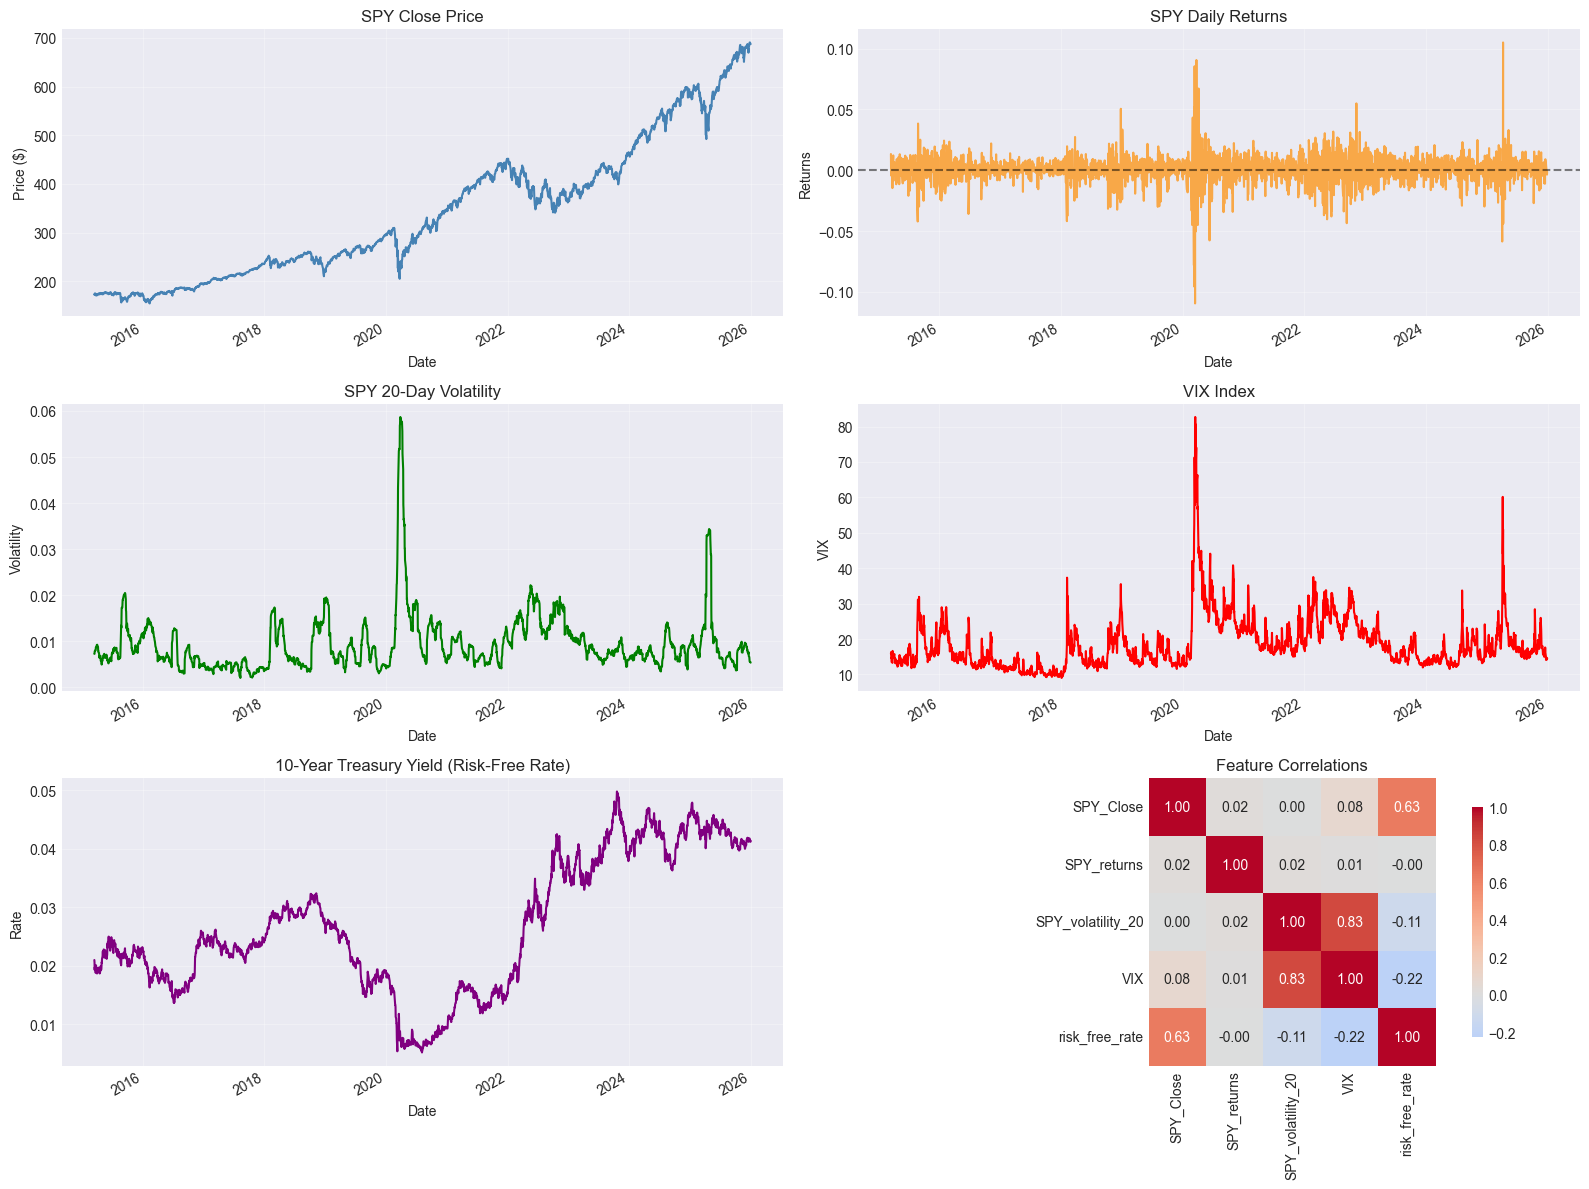

In [319]:
# Final visualization - Key processed features
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# SPY price and returns
main_df['SPY_Close'].plot(ax=axes[0, 0], title='SPY Close Price', color='steelblue')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

main_df['SPY_returns'].plot(ax=axes[0, 1], title='SPY Daily Returns', color='darkorange', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_ylabel('Returns')
axes[0, 1].grid(True, alpha=0.3)

# Volatility
main_df['SPY_volatility_20'].plot(ax=axes[1, 0], title='SPY 20-Day Volatility', color='green')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].grid(True, alpha=0.3)

main_df['VIX'].plot(ax=axes[1, 1], title='VIX Index', color='red')
axes[1, 1].set_ylabel('VIX')
axes[1, 1].grid(True, alpha=0.3)

# Risk-free rate and correlation
main_df['risk_free_rate'].plot(ax=axes[2, 0], title='10-Year Treasury Yield (Risk-Free Rate)', color='purple')
axes[2, 0].set_ylabel('Rate')
axes[2, 0].grid(True, alpha=0.3)

# Correlation heatmap (sample of key features)
key_features = ['SPY_Close', 'SPY_returns', 'SPY_volatility_20', 'VIX', 'risk_free_rate']
corr = main_df[key_features].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[2, 1], cbar_kws={'shrink': 0.8})
axes[2, 1].set_title('Feature Correlations')

plt.tight_layout()
plt.show()

## Summary

### ✅ Data Processing Complete!

**Processed Datasets:**
1. `market_data_processed.csv` - Main dataset with all features
2. `spy_options_processed.csv` - Processed options chain data
3. Individual ticker files (SPY, AAPL, QQQ, IWM, GLD, VIX)
4. `metadata.json` - Processing metadata

**Features Created:**
- Price data (OHLC)
- Returns (simple and log)
- Volatility (rolling 20-day)
- Technical indicators (SMA, EMA, momentum)
- VIX (market volatility)
- Risk-free rate (10Y Treasury)
- Option Greeks (calculated on-demand)

**Next Steps:**
1. Use `market_data_processed.csv` for RL environment training
2. Load processed data in training scripts
3. Run backtests with historical data
4. Evaluate hedging strategies

**Usage Example:**
```python
import pandas as pd
df = pd.read_csv('data/processed/market_data_processed.csv', index_col=0, parse_dates=True)
```